### Gap Junction Segmentation Model Training Pipeline

In [1]:
#Libraries
import torch
from torch import nn
from utilities import UpBlock, DownBlock, DoubleConv, GenDLoss, FocalLoss
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import BinaryRecall, BinaryPrecision, BinaryF1Score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import os
import cv2
from tqdm.notebook import tqdm #Change to tqdm.tqdm if not using Jupyter Notebook
import copy
import wandb
#Custom Libraries
from resize_image import resize_image

#### Set Reproducible Seeds

In [2]:
def seed_everything(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False
    
def worker_init_fn(worker_id):
    seed = 42 + worker_id
    np.random.seed(seed)
    torch.manual_seed(seed)
    
seed_everything(42)

#### Define Augmentation Options

In [ ]:
# Custom augmentation
def get_custom_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Affine(scale=(0.9,1.1), rotate=10, translate_percent=0.15, shear = (-5, 5), p=0.9),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=0.5),
        A.GaussNoise(p=0.3),
        A.Normalize(mean=0.0, std=1.0),
        A.Resize(512, 512),
        ToTensorV2()
    ])
    
def get_custom_augmentation2():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Affine(scale=(0.8,1.2), rotate=360, translate_percent=0.15, shear=(-15, 15), p=0.9),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GaussNoise(p=0.3),
        A.Normalize(mean=0.0, std=1.0),
        A.Resize(512, 512),
        ToTensorV2()
    ])



#### Make Dataset Class

In [4]:
#Class can load any mask as long as the model corresponds to the mask type
class TrainingDataset(Dataset):
    def __init__(self, images, labels, masks=None, augmentation=None, data_size=(512, 512), train=True):
        self.image_paths = sorted([os.path.join(images, img) for img in os.listdir(images)])
        self.label_paths = sorted([os.path.join(labels, lbl) for lbl in os.listdir(labels)])
        self.mask_paths = sorted([os.path.join(masks, mask) for mask in os.listdir(masks)]) if masks else None
        self.augmentation = augmentation
        self.data_size = data_size
        self.train = train

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        #Read image, label, and mask
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(self.label_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE) if self.mask_paths else None
        
        #Apply resizing with padding if image is not expected size and then convert back to ndarray
        if (image.shape[0] != self.data_size[0]) or (image.shape[1] != self.data_size[1]): 
            image = np.array(resize_image(image, self.data_size[0], self.data_size[1], (0,0,0)))
            label = np.array(resize_image(label, self.data_size[0], self.data_size[1], (0,0,0)))
            if mask is not None:
                mask = np.array(resize_image(mask, self.data_size[0], self.data_size[1], (0,0,0)))

        #Convert mask/label to binary for model classification
        label[label > 0] = 1
        if mask is not None:
            mask[mask > 0] = 1
        
        #Apply augmentation if provided
        if self.augmentation and self.train:
            if mask is not None:
                #Use mask in augmentation
                augmented = self.augmentation(image=image, mask=label, label=mask)
                image = augmented['image']
                label = augmented['mask']
                mask = augmented['label']
            else:
                #Without mask
                augmented = self.augmentation(image=image, mask=label)
                image = augmented['image']
                label = augmented['mask']

        #Add entity recognition clause later if needed
        
        # Convert to tensors if not already converted from augmentation
        if not torch.is_tensor(image):
            image = ToTensor()(image).float()
        if not torch.is_tensor(label):
            label = torch.from_numpy(label).long()
        if mask is not None and not torch.is_tensor(mask):
            mask = torch.from_numpy(mask).long()
        elif mask is None:
            mask = torch.zeros_like(label)

        return image, label, mask

#### Set Augmentation

In [8]:
#For training with augmentation
train_augmentation = get_custom_augmentation()  # Change to get_medium_augmentation() or get_heavy_augmentation() as needed

# For validation without augmentation
valid_augmentation = A.Compose([
    A.Normalize(mean=0.0, std=1.0),
    ToTensorV2()
])

#### Initialize and Load Datasets

In [9]:
train = TrainingDataset(
    images="/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/imgs",
    labels="/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/gts",
    augmentation=train_augmentation,
    train=True,
)

valid = TrainingDataset(
    images="/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s200-209/imgs",
    labels="/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s200-209/gts",
    augmentation=valid_augmentation,
    train=False
)

train_dataloader = DataLoader(train, batch_size=8, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid, batch_size=8, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

#### Initialize model and send to gpu

In [5]:
class UNet(nn.Module):
    """UNet Architecture"""
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose', three=False, attend=False, residual=False, scale=False, spatial=False, dropout=0, classes=2):
        """Initialize the UNet model"""
        super(UNet, self).__init__()
        self.three = three
        self.up_sample_mode = up_sample_mode
        self.dropout=dropout

        # Downsampling Path
        self.down_conv1 = DownBlock(1, 64, three=three, spatial=False, residual=residual) # 3 input channels --> 64 output channels
        self.down_conv2 = DownBlock(64, 128, three=three, spatial=spatial, dropout=self.dropout, residual=residual) # 64 input channels --> 128 output channels
        self.down_conv3 = DownBlock(128, 256, spatial=spatial, dropout=self.dropout, residual=residual) # 128 input channels --> 256 output channels
        self.down_conv4 = DownBlock(256, 512, spatial=spatial, dropout=self.dropout, residual=residual) # 256 input channels --> 512 output channels
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024,spatial=spatial, dropout=self.dropout, residual=residual)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode, dropout=self.dropout, residual=residual) # 512 + 1024 input channels --> 512 output channels
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode, dropout=self.dropout, residual=residual)
        self.up_conv2 = UpBlock(128+ 256, 128, self.up_sample_mode, dropout=self.dropout, residual=residual)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, 1 if classes == 2 else classes, kernel_size=1)
        self.attend = attend
        if scale:
            self.s1, self.s2 = torch.nn.Parameter(torch.ones(1), requires_grad=True), torch.nn.Parameter(torch.ones(1), requires_grad=True) # learn scaling


    def forward(self, x):
        """Forward pass of the UNet model
        x: (16, 1, 512, 512)
        """
        # print(x.shape)
        x, skip1_out = self.down_conv1(x) # x: (16, 64, 256, 256), skip1_out: (16, 64, 512, 512) (batch_size, channels, height, width)    
        x, skip2_out = self.down_conv2(x) # x: (16, 128, 128, 128), skip2_out: (16, 128, 256, 256)
        if self.three: x = x.squeeze(-3)   
        x, skip3_out = self.down_conv3(x) # x: (16, 256, 64, 64), skip3_out: (16, 256, 128, 128)
        x, skip4_out = self.down_conv4(x) # x: (16, 512, 32, 32), skip4_out: (16, 512, 64, 64)
        x = self.double_conv(x) # x: (16, 1024, 32, 32)
        x = self.up_conv4(x, skip4_out) # x: (16, 512, 64, 64)
        x = self.up_conv3(x, skip3_out) # x: (16, 256, 128, 128)
        if self.three: 
            #attention_mode???
            skip1_out = torch.mean(skip1_out, dim=2)
            skip2_out = torch.mean(skip2_out, dim=2)
        x = self.up_conv2(x, skip2_out) # x: (16, 128, 256, 256)
        x = self.up_conv1(x, skip1_out) # x: (16, 64, 512, 512)
        x = self.conv_last(x) # x: (16, 1, 512, 512)
        return x
    
device = torch.device("cuda")    
model = UNet().to(device)

#### Initialize loss function and optimizer

In [11]:
loss_fn = GenDLoss()
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6)

In [12]:
#Send evaluation metrics to device
recall = BinaryRecall().to(device)
precision = BinaryPrecision().to(device)
f1 = BinaryF1Score().to(device)

#### Define Training and Validation Process

In [13]:
#Define training function
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = 0
    num_batches = len(dataloader)
    
    #Reset metrics for each epoch
    recall.reset()
    precision.reset()
    f1.reset()
    
    for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training Batches"):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        #Calculate metrics after converting predictions to binary
        pred_binary = (torch.sigmoid(pred) > 0.5).squeeze(1) #Remove channel dimension to match y
        
        #Update metrics
        recall.update(pred_binary, y)
        precision.update(pred_binary, y)
        f1.update(pred_binary, y)
        
        train_loss += loss.item()

    #Compute final metrics per epoch
    train_recall = recall.compute().item()
    train_precision = precision.compute().item()
    train_f1 = f1.compute().item()
    train_loss_per_epoch = train_loss / num_batches 
    
    return train_loss_per_epoch, train_recall, train_precision, train_f1


In [14]:
#Define validation function
def validate(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0
    num_batches = len(dataloader)
    
    #Reset metrics for each epoch
    recall.reset()
    precision.reset()
    f1.reset()
    
    with torch.no_grad():
        for X, y, _ in tqdm(dataloader, desc="Validation Batches"):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
        #Calculate metrics
        pred_binary = (torch.sigmoid(pred) > 0.5).squeeze(1) #Remove channel dimension to match y
        
        #Update metrics
        recall.update(pred_binary, y)
        precision.update(pred_binary, y)
        f1.update(pred_binary, y)
            
        #Compute final metrics per epoch
        val_recall = recall.compute().item()
        val_precision = precision.compute().item()
        val_f1 = f1.compute().item()
        val_loss_per_epoch = test_loss / num_batches

    return val_loss_per_epoch, val_recall, val_precision, val_f1
    print(f"Avg loss: {test_loss:>7f}\n")
    

In [ ]:
#WandB Initialization
wandb.login(key="04e003d2c64e518f8033ab016c7a0036545c05f5")
wandb.init(project="gap-junction-segmentation", 
           entity="zhen_lab",
           name="unet_pooled_run_1",
           dir="/home/tommytang111/gap-junction-segmentation/wandb/unet_pooled_runs",
           reinit=True,
           config={
               "learning_rate": 0.001,
               "batch_size": 8,
               "epochs": 30,
               "image_size": (512, 512),
               "loss_function": "Generalized Dice Loss",
               "optimizer": "Adam",
               "scheduler": "ReduceLROnPlateau"
           }
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc
wandb: Currently logged in as: tommytang111 (zhen_lab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


#### Run Training

In [ ]:
# Clear GPU memory before training
torch.cuda.empty_cache()

epochs = 50
best_f1 = 0.0
best_val_loss = float('inf')
best_epoch = 0
best_model_state = copy.deepcopy(model.state_dict())

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    
    #Training
    train_loss, train_recall, train_precision, train_f1 = train(train_dataloader, model, loss_fn, optimizer)

    #Validation
    val_loss, val_recall, val_precision, val_f1 = validate(valid_dataloader, model, loss_fn)

    #Update learning rate scheduler
    scheduler.step(val_loss)
    
    #Print metrics
    print(f"Train | Loss: {train_loss:.4f}, Recall: {train_recall:.4f}, Precision: {train_precision:.4f}, F1: {train_f1:.4f}")
    print(f"Val   | Loss: {val_loss:.4f}, Recall: {val_recall:.4f}, Precision: {val_precision:.4f}, F1: {val_f1:.4f}")
    print("-----------------------------")
    
    #Log best model state based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
    
    #Log best model state based on F1 score
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_epoch = epoch
        best_model_state = copy.deepcopy(model.state_dict())
        
    #Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_recall": train_recall,
        "train_precision": train_precision,
        "train_f1": train_f1,
        "val_loss": val_loss,
        "val_recall": val_recall,
        "val_precision": val_precision,
        "val_f1": val_f1,
        "best_val_f1": best_f1,
        "best_val_loss": best_val_loss,
        "best_epoch": best_epoch,
        "lr": optimizer.param_groups[0]["lr"]
    })

print("Training Complete!")
wandb.finish()

Epoch 1


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9567, Recall: 0.2601, Precision: 0.0221, F1: 0.0408
Val   | Loss: 0.9300, Recall: 0.9825, Precision: 0.0341, F1: 0.0660
-----------------------------
Epoch 2


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9580, Recall: 0.2990, Precision: 0.0212, F1: 0.0395
Val   | Loss: 0.9281, Recall: 0.9831, Precision: 0.0343, F1: 0.0664
-----------------------------
Epoch 3


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9568, Recall: 0.2420, Precision: 0.0219, F1: 0.0402
Val   | Loss: 0.8956, Recall: 0.0103, Precision: 0.0132, F1: 0.0115
-----------------------------
Epoch 4


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2460, Precision: 0.0242, F1: 0.0441
Val   | Loss: 0.8746, Recall: 0.1495, Precision: 0.1403, F1: 0.1447
-----------------------------
Epoch 5


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9564, Recall: 0.1940, Precision: 0.0229, F1: 0.0410
Val   | Loss: 0.9345, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 6


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.1739, Precision: 0.0252, F1: 0.0440
Val   | Loss: 0.9254, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 7


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9567, Recall: 0.0530, Precision: 0.0292, F1: 0.0376
Val   | Loss: 0.9257, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 8


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.0000, Precision: 0.0286, F1: 0.0001
Val   | Loss: 0.9139, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 9


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9583, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.9135, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 10


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9578, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.9193, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 11


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9569, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.9133, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 12


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9562, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.9257, Recall: 0.0001, Precision: 0.0332, F1: 0.0002
-----------------------------
Epoch 13


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9531, Recall: 0.0005, Precision: 0.0142, F1: 0.0009
Val   | Loss: 0.8888, Recall: 0.0018, Precision: 0.0528, F1: 0.0035
-----------------------------
Epoch 14


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9503, Recall: 0.0386, Precision: 0.0281, F1: 0.0325
Val   | Loss: 0.9297, Recall: 0.0325, Precision: 0.0302, F1: 0.0313
-----------------------------
Epoch 15


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9414, Recall: 0.0468, Precision: 0.0370, F1: 0.0414
Val   | Loss: 0.9309, Recall: 0.0341, Precision: 0.0294, F1: 0.0316
-----------------------------
Epoch 16


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9343, Recall: 0.0440, Precision: 0.0412, F1: 0.0426
Val   | Loss: 0.9306, Recall: 0.0332, Precision: 0.0281, F1: 0.0305
-----------------------------
Epoch 17


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9311, Recall: 0.0772, Precision: 0.0439, F1: 0.0559
Val   | Loss: 0.9339, Recall: 0.0441, Precision: 0.0277, F1: 0.0341
-----------------------------
Epoch 18


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9303, Recall: 0.0852, Precision: 0.0454, F1: 0.0592
Val   | Loss: 0.9324, Recall: 0.0469, Precision: 0.0306, F1: 0.0370
-----------------------------
Epoch 19


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9298, Recall: 0.0639, Precision: 0.0456, F1: 0.0532
Val   | Loss: 0.9300, Recall: 0.0312, Precision: 0.0286, F1: 0.0298
-----------------------------
Epoch 20


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9284, Recall: 0.0714, Precision: 0.0511, F1: 0.0596
Val   | Loss: 0.9345, Recall: 0.0317, Precision: 0.0273, F1: 0.0294
-----------------------------
Epoch 21


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9315, Recall: 0.0601, Precision: 0.0431, F1: 0.0502
Val   | Loss: 0.9314, Recall: 0.0301, Precision: 0.0297, F1: 0.0299
-----------------------------
Epoch 22


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9232, Recall: 0.0824, Precision: 0.0510, F1: 0.0630
Val   | Loss: 0.9323, Recall: 0.0318, Precision: 0.0287, F1: 0.0302
-----------------------------
Epoch 23


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9233, Recall: 0.0868, Precision: 0.0467, F1: 0.0607
Val   | Loss: 0.9365, Recall: 0.0360, Precision: 0.0266, F1: 0.0306
-----------------------------
Epoch 24


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9227, Recall: 0.0855, Precision: 0.0496, F1: 0.0628
Val   | Loss: 0.9288, Recall: 0.0306, Precision: 0.0309, F1: 0.0308
-----------------------------
Epoch 25


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9257, Recall: 0.0803, Precision: 0.0450, F1: 0.0577
Val   | Loss: 0.9284, Recall: 0.0302, Precision: 0.0311, F1: 0.0306
-----------------------------
Epoch 26


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9234, Recall: 0.0844, Precision: 0.0473, F1: 0.0606
Val   | Loss: 0.9280, Recall: 0.0271, Precision: 0.0318, F1: 0.0293
-----------------------------
Epoch 27


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9188, Recall: 0.0843, Precision: 0.0527, F1: 0.0648
Val   | Loss: 0.9279, Recall: 0.0269, Precision: 0.0317, F1: 0.0291
-----------------------------
Epoch 28


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9198, Recall: 0.0829, Precision: 0.0523, F1: 0.0641
Val   | Loss: 0.9279, Recall: 0.0270, Precision: 0.0318, F1: 0.0292
-----------------------------
Epoch 29


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9218, Recall: 0.0764, Precision: 0.0506, F1: 0.0609
Val   | Loss: 0.9282, Recall: 0.0252, Precision: 0.0319, F1: 0.0282
-----------------------------
Epoch 30


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9150, Recall: 0.0829, Precision: 0.0577, F1: 0.0680
Val   | Loss: 0.9285, Recall: 0.0249, Precision: 0.0318, F1: 0.0279
-----------------------------
Epoch 31


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9213, Recall: 0.0703, Precision: 0.0512, F1: 0.0592
Val   | Loss: 0.9287, Recall: 0.0246, Precision: 0.0316, F1: 0.0277
-----------------------------
Epoch 32


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9208, Recall: 0.0684, Precision: 0.0535, F1: 0.0600
Val   | Loss: 0.9287, Recall: 0.0244, Precision: 0.0314, F1: 0.0275
-----------------------------
Epoch 33


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9197, Recall: 0.0705, Precision: 0.0538, F1: 0.0610
Val   | Loss: 0.9289, Recall: 0.0259, Precision: 0.0311, F1: 0.0283
-----------------------------
Epoch 34


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9234, Recall: 0.0659, Precision: 0.0498, F1: 0.0567
Val   | Loss: 0.9289, Recall: 0.0264, Precision: 0.0314, F1: 0.0286
-----------------------------
Epoch 35


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9171, Recall: 0.0736, Precision: 0.0564, F1: 0.0639
Val   | Loss: 0.9290, Recall: 0.0263, Precision: 0.0312, F1: 0.0285
-----------------------------
Epoch 36


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9240, Recall: 0.0606, Precision: 0.0486, F1: 0.0540
Val   | Loss: 0.9293, Recall: 0.0250, Precision: 0.0309, F1: 0.0276
-----------------------------
Epoch 37


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9171, Recall: 0.0708, Precision: 0.0584, F1: 0.0640
Val   | Loss: 0.9293, Recall: 0.0263, Precision: 0.0311, F1: 0.0285
-----------------------------
Epoch 38


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9210, Recall: 0.0688, Precision: 0.0523, F1: 0.0594
Val   | Loss: 0.9294, Recall: 0.0264, Precision: 0.0310, F1: 0.0285
-----------------------------
Epoch 39


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9195, Recall: 0.0753, Precision: 0.0551, F1: 0.0637
Val   | Loss: 0.9292, Recall: 0.0267, Precision: 0.0311, F1: 0.0287
-----------------------------
Epoch 40


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9229, Recall: 0.0704, Precision: 0.0497, F1: 0.0583
Val   | Loss: 0.9291, Recall: 0.0257, Precision: 0.0308, F1: 0.0280
-----------------------------
Epoch 41


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9176, Recall: 0.0814, Precision: 0.0581, F1: 0.0678
Val   | Loss: 0.9288, Recall: 0.0251, Precision: 0.0315, F1: 0.0279
-----------------------------
Epoch 42


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9160, Recall: 0.0813, Precision: 0.0581, F1: 0.0678
Val   | Loss: 0.9287, Recall: 0.0251, Precision: 0.0316, F1: 0.0280
-----------------------------
Epoch 43


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9185, Recall: 0.0787, Precision: 0.0565, F1: 0.0658
Val   | Loss: 0.9286, Recall: 0.0250, Precision: 0.0317, F1: 0.0280
-----------------------------
Epoch 44


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9198, Recall: 0.0719, Precision: 0.0534, F1: 0.0612
Val   | Loss: 0.9285, Recall: 0.0243, Precision: 0.0313, F1: 0.0273
-----------------------------
Epoch 45


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9159, Recall: 0.0791, Precision: 0.0578, F1: 0.0668
Val   | Loss: 0.9283, Recall: 0.0248, Precision: 0.0316, F1: 0.0278
-----------------------------
Epoch 46


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9180, Recall: 0.0750, Precision: 0.0548, F1: 0.0633
Val   | Loss: 0.9284, Recall: 0.0242, Precision: 0.0313, F1: 0.0273
-----------------------------
Epoch 47


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9153, Recall: 0.0792, Precision: 0.0576, F1: 0.0667
Val   | Loss: 0.9283, Recall: 0.0252, Precision: 0.0318, F1: 0.0281
-----------------------------
Epoch 48


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9207, Recall: 0.0760, Precision: 0.0522, F1: 0.0619
Val   | Loss: 0.9283, Recall: 0.0268, Precision: 0.0315, F1: 0.0289
-----------------------------
Epoch 49


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9188, Recall: 0.0795, Precision: 0.0525, F1: 0.0632
Val   | Loss: 0.9283, Recall: 0.0268, Precision: 0.0315, F1: 0.0290
-----------------------------
Epoch 50


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9217, Recall: 0.0774, Precision: 0.0511, F1: 0.0615
Val   | Loss: 0.9284, Recall: 0.0267, Precision: 0.0314, F1: 0.0288
-----------------------------
Epoch 51


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9201, Recall: 0.0799, Precision: 0.0533, F1: 0.0639
Val   | Loss: 0.9284, Recall: 0.0266, Precision: 0.0313, F1: 0.0288
-----------------------------
Epoch 52


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9198, Recall: 0.0802, Precision: 0.0539, F1: 0.0644
Val   | Loss: 0.9285, Recall: 0.0265, Precision: 0.0314, F1: 0.0288
-----------------------------
Epoch 53


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9181, Recall: 0.0818, Precision: 0.0556, F1: 0.0662
Val   | Loss: 0.9286, Recall: 0.0259, Precision: 0.0310, F1: 0.0282
-----------------------------
Epoch 54


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9155, Recall: 0.0842, Precision: 0.0581, F1: 0.0688
Val   | Loss: 0.9286, Recall: 0.0252, Precision: 0.0317, F1: 0.0281
-----------------------------
Epoch 55


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9221, Recall: 0.0720, Precision: 0.0506, F1: 0.0595
Val   | Loss: 0.9286, Recall: 0.0251, Precision: 0.0317, F1: 0.0280
-----------------------------
Epoch 56


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9210, Recall: 0.0758, Precision: 0.0535, F1: 0.0627
Val   | Loss: 0.9286, Recall: 0.0251, Precision: 0.0317, F1: 0.0280
-----------------------------
Epoch 57


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9177, Recall: 0.0769, Precision: 0.0549, F1: 0.0641
Val   | Loss: 0.9286, Recall: 0.0251, Precision: 0.0317, F1: 0.0280
-----------------------------
Epoch 58


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9190, Recall: 0.0737, Precision: 0.0530, F1: 0.0617
Val   | Loss: 0.9287, Recall: 0.0249, Precision: 0.0315, F1: 0.0278
-----------------------------
Epoch 59


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9141, Recall: 0.0827, Precision: 0.0592, F1: 0.0690
Val   | Loss: 0.9288, Recall: 0.0249, Precision: 0.0314, F1: 0.0278
-----------------------------
Epoch 60


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9242, Recall: 0.0707, Precision: 0.0500, F1: 0.0586
Val   | Loss: 0.9288, Recall: 0.0248, Precision: 0.0313, F1: 0.0277
-----------------------------
Epoch 61


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9231, Recall: 0.0728, Precision: 0.0507, F1: 0.0598
Val   | Loss: 0.9288, Recall: 0.0246, Precision: 0.0312, F1: 0.0275
-----------------------------
Epoch 62


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9182, Recall: 0.0801, Precision: 0.0552, F1: 0.0653
Val   | Loss: 0.9288, Recall: 0.0246, Precision: 0.0312, F1: 0.0275
-----------------------------
Epoch 63


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Save Best Model

In [12]:
#Save the best logged model state
torch.save(best_model_state, "/home/tommytang111/gap-junction-segmentation/models/unet_v1.pt")
print("Saved PyTorch Model to unet_v1.pt")

Saved PyTorch Model to unet_v1.pt


#### Troubleshooting

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

aug = get_custom_augmentation()

img_dir = "/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/imgs"
label_dir = "/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/gts"
img_files = os.listdir(img_dir)

for i in range(5):
    #Take a random image
    img_name = np.random.choice(img_files)
    img_path = os.path.join(img_dir, img_name)
    
    # Build corresponding label filename
    base, ext = os.path.splitext(img_name)
    label_name = f"{base}_label{ext}"
    label_path = os.path.join(label_dir, label_name)

    # Read image and label
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    #Optional
    #image = cv2.resize(image, (512, 512))
    #label = cv2.resize(label, (512, 512))

    # Albumentations expects HWC, so expand dims for grayscale
    image = np.expand_dims(image, axis=-1)
    label = np.expand_dims(label, axis=-1)

    # Apply augmentation (pass label as 'mask')
    augmented = aug(image=image, mask=label)
    aug_img = augmented['image'].squeeze().cpu().numpy()
    aug_label = augmented['mask'].squeeze().cpu().numpy()

    plt.figure(figsize=(4, 4)) 
    plt.subplot(2, 2, 1)
    plt.title("Original Image")
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.title("Original Label")
    plt.imshow(label.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.title("Augmented Image")
    plt.imshow(aug_img, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.title("Augmented Label")
    plt.imshow(aug_label, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

NameError: name 'get_custom_augmentation' is not defined

In [6]:
print(img_path)
print(label_path)

/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/imgs/SEM_adult_image_export_s255_part4.png
/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/gts/SEM_adult_image_export_s255_part4_label.png


Showing image /home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/gts/SEM_adult_image_export_s252_part2_label.png
True


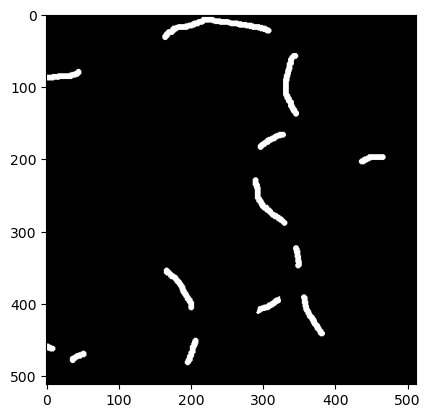

In [27]:
import random
import matplotlib.pyplot as plt
path = "/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/gts"
image = os.path.join(path, random.choice(os.listdir(path)))
print(f"Showing image {image}")
image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
print(np.any(image == 1))
plt.imshow(image, cmap='gray')

In [28]:
#Check for blank masks in mask directory
non_black_images = 0
black_images = 0
count = 0
for image in os.listdir(path):
    image_path = os.path.join(path, image)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if np.any(img == 1):
        non_black_images += 1
    else:
        black_images += 1
    count += 1
print(f"Non-black images: {non_black_images}/{count}, Black images: {black_images}/{count}")

Non-black images: 40/40, Black images: 0/40
